### Modelagem do modelo de series temporais

O modelo **SARIMAX** foi escolhido para esta análise por ser uma extensão do modelo ARIMA que incorpora a componente sazonal "S", essencial para capturar padrões periódicos na série temporal. Além disso, o SARIMAX permite a inclusão de variáveis exógenas (fatores externos), possibilitando a análise de como variáveis adicionais podem influenciar o comportametno da série principal ao longo do tempo.

Esse modelo é o modelo SARIMA, que combina os componentes ARIMA para modelar tendências não sazonais e componentes sazonais específicos para lidar com padrões que se repetem em intervalores regulares.

Parâmetros **não** sazonais

- p (autoregressive - AR): Número de defasagens da série temporal (lag).
- d (difference): número de diferenciações necessárias para tornar a série estacionária
- q (moving average - MA): Número de defasagens nos erros (resíduos)

Parâmetros sazonais

- P (sazonal AR): Número de defasagens sazonais.
- D (sazonal difference): Número de diferenciações sazonais.
- Q (sazonal MA): Número de médias móveis sazonais.
- S (sazonalidade): período da sazonalidade (ex: 12 para dados mensais com padrão anual).

O parâmetro X em SARIMAX representa a inclusão de variáveis exógenas no modelo. São variáveis externas que podem influênciar a série que está sendo modelada.


In [108]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [72]:
dados_modelo = pd.read_csv(r"C:\Users\eduar\OneDrive\Documentos\SandoBox\Projetos\PriceCast\Dataset\dados_preprocessados.csv",  index_col=0)
dados_modelo.head()

,populacao_pessoas,leite_uht_industria,leite_uht_supermercado,preco_leite_produtor
data,,,,
2007-02-01,0.000850,0.0,-0.007398,0.062721
2007-03-01,0.000849,0.0,0.010707,0.042416
2007-04-01,0.000849,0.0,0.030502,0.083423
2007-05-01,0.000848,0.0,0.092346,0.073984
2007-06-01,0.000847,0.0,0.151256,0.097514


In [73]:
dados_modelo = dados_modelo.drop(columns = ['populacao_pessoas'], axis = 1)

In [74]:
dados_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 2007-02-01 to 2024-12-01
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   leite_uht_industria     198 non-null    float64
 1   leite_uht_supermercado  198 non-null    float64
 2   preco_leite_produtor    198 non-null    float64
dtypes: float64(3)
memory usage: 6.2+ KB


Percebe-se que possui alguns meses faltando em determinados anos, com esse tipo de comportamento, a nossa série temporal se torna irregular, para isso faremos alguns processos para torna-la regular.

In [75]:
dados_modelo.index = pd.to_datetime(dados_modelo.index).to_period('M').to_timestamp()

index_mensal = pd.date_range(
    start=dados_modelo.index.min(),
    end=dados_modelo.index.max(),
    freq='MS'
)

dados_modelo_tratado = dados_modelo.reindex(index=index_mensal)

Podemos observar que existe valores nulos no nosso dataframe, o que é esperado, pois não tinha informações de um determinado mês e com isso foi gerado um registro com aquela data o que resultado em nulo.

In [76]:
dados_modelo_tratado.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2007-02-01 to 2024-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   leite_uht_industria     198 non-null    float64
 1   leite_uht_supermercado  198 non-null    float64
 2   preco_leite_produtor    198 non-null    float64
dtypes: float64(3)
memory usage: 6.7 KB


### Técnica de Interpolação Linear

É uma técnica de preenchimento de valores ausentes baseada em uma suposição simples: os dados variam de forma linear entre dois pontos conhecidos. Quando usada neste caso, relacioando a séries temporais, essa técnica estima os valores ausentes ao traçar uma linha reta entre o ponto anterior e o posterior preenchendo os valores nulos com valores proporcionais ao intervalo entre eles.

In [77]:
dados_modelo_tratado = dados_modelo_tratado.interpolate(method='spline', order=3)

In [78]:
dados_modelo_tratado.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2007-02-01 to 2024-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   leite_uht_industria     215 non-null    float64
 1   leite_uht_supermercado  215 non-null    float64
 2   preco_leite_produtor    215 non-null    float64
dtypes: float64(3)
memory usage: 6.7 KB


### Divisão de treino e teste

Quando se trata de séries temporais, a divisão entre dados de treinamento e teste, deve respeitar a ordem temporal dos dados. Isso significa que não se deve dividir os dados de forma aleatória, como é normalmente feito em problemas de classificação ou regressão. Pois, cada observação está dependendo do tempo. Isso significa que os dados mais recentes dependem dos valores passados para serem previstos. Se embaralhar os dados de forma aleatória irá aver uma quebra na sequência temporal  natural, o modelo pode acabar treinando com dados mais recentes e sendo testado em dados anteriores o que é irrealista para previsões futuras.


In [79]:
# Definindo a proporção de treino (80%)
dados_treinamento = int(len(dados_modelo_tratado) * 0.8)

treino = dados_modelo.iloc[:dados_treinamento]
teste = dados_modelo.iloc[dados_treinamento:]

In [80]:

y_train = treino['preco_leite_produtor']
y_test = teste['preco_leite_produtor']
X_train = treino.drop(columns='preco_leite_produtor')
X_test = teste.drop(columns='preco_leite_produtor')


X_train.index = pd.to_datetime(X_train.index, errors='coerce')
X_test.index = pd.to_datetime(X_test.index, errors='coerce')
y_train.index = pd.to_datetime(y_train.index, errors='coerce')
y_test.index = pd.to_datetime(y_test.index, errors='coerce')

#Remover linhas com índice inválido (caso existam)
valid_index_train = X_train.index.notna() & y_train.index.notna()
X_train = X_train[valid_index_train]
y_train = y_train[valid_index_train]

valid_index_test = X_test.index.notna() & y_test.index.notna()
X_test = X_test[valid_index_test]
y_test = y_test[valid_index_test]

# Interpolar valores faltantes se necessário
X_train = X_train.interpolate()
X_test = X_test.interpolate()
y_train = y_train.interpolate()
y_test = y_test.interpolate()

X_train = X_train.asfreq('MS', method='pad')
y_train = y_train.asfreq('MS', method='pad')
X_test = X_test.asfreq('MS', method='pad')
y_test = y_test.asfreq('MS', method='pad')


In [81]:
# Manter apenas datas em que ambos possuem dados válidos
common_index = X_train.index.intersection(y_train.index)

X_train_clean = X_train.loc[common_index]
y_train_clean = y_train.loc[common_index]

### Escolhendo os melhores parâmetros para o Modelo SARIMAX, utilizando o Auto_Arima

In [82]:
modelo_auto = auto_arima(
    y_train_clean,
    exogenous=X_train_clean,    # variável exógena
    seasonal=True,
    m=12,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    max_p=5, max_q=5,
    max_P=2, max_Q=2,
    max_d=2, max_D=1
)

print(modelo_auto.summary())
print(f"\nMelhor modelo ARIMA: {modelo_auto.order} com sazonalidade {modelo_auto.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-611.049, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-517.484, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-608.331, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-611.920, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-518.085, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-607.446, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-617.943, Time=1.00 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-621.936, Time=1.34 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=-618.796, Time=1.47 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=-541.775, Time=0.50 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-626.183, Time=1.79 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-622.983, Time=1.23 sec
 ARIMA(1,0,1)(1,0,1)[12] inte

Definindo o modelo SARIMAX com os parâmetros escolhidos

In [83]:
modelo_sarimax = SARIMAX(
    endog= y_train_clean,
    exog = X_train_clean,
    order=(1, 0, 1),
    seasonal_order= (1, 0, 1, 12),
    enforce_stationarity= False,
    enforce_invertibility=False
)

resultado = modelo_sarimax.fit(disp=False, maxiter=300, method='lbfgs')
print(resultado.summary())

                                     SARIMAX Results                                      
Dep. Variable:               preco_leite_produtor   No. Observations:                  189
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 366.208
Date:                            Sun, 25 May 2025   AIC                           -718.417
Time:                                    11:35:49   BIC                           -696.263
Sample:                                02-01-2007   HQIC                          -709.430
                                     - 10-01-2022                                         
Covariance Type:                              opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
leite_uht_industria        0.2612      0.021     12.262      0.000       0.219       0.303

In [84]:
# Fazendo previsões
y_pred = resultado.predict(start = y_test.index.min(), end = y_test.index.max(), exog = X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE no conjunto de teste: {rmse:.4f}')

RMSE no conjunto de teste: 0.0268
R² no conjunto de teste: 0.6968


### Revertendo as transformações

Nos dados utilizados, aplicamos duas transformações sequenciais: primeiro, a transformação logarítmica, seguida da diferenciação. Embora o RMSE obtido seja de 0,0268, esse valor refere-se aos dados transformados e não à escala original dos preços.

Para interpretar corretamente a performance do modelo, é necessário reverter essas transformações e trazer as previsões de volta à escala real dos dados. A seguir, será realizado esse processo de reversão para obter os valores na unidade original.

In [96]:
# Carregando o dataset original

dados_certos = pd.read_csv(r"C:\Users\eduar\OneDrive\Documentos\SandoBox\Projetos\PriceCast\Dataset\dados_certos.csv", index_col= 0)
dados_certos.index = pd.to_datetime(dados_certos.index, errors='coerce')

print(dados_certos.head())

            leite_uht_industria  leite_uht_supermercado  preco_leite_produtor
data                                                                         
2007-01-01             2.983468                1.422492              0.450872
2007-02-01             2.983468                1.412007              0.480057
2007-03-01             2.983468                1.427207              0.500857
2007-04-01             2.983468                1.471410              0.544433
2007-05-01             2.983468                1.613760              0.586239


In [98]:
dados_certos['preco_leite_produtor']

data
2007-01-01    0.450872
2007-02-01    0.480057
2007-03-01    0.500857
2007-04-01    0.544433
2007-05-01    0.586239
                ...   
2024-08-01    2.760700
2024-09-01    2.865700
2024-10-01    2.806500
2024-11-01    2.637400
2024-12-01    2.580500
Name: preco_leite_produtor, Length: 199, dtype: float64

In [97]:
dados_certos[['preco_leite_produtor']].head(3)

,preco_leite_produtor
data,
2007-01-01,0.450872
2007-02-01,0.480057
2007-03-01,0.500857


### O processo de reconstrução será feito em algumas partes

- Guardar uma cópia da série original.

Salvamos uma cópia da série original do preço do leite. Isso é importante para que possamos comparar nossas previsões com os valores reais na escala orginal.

- Aplicar o logaritmo na série temporal.

Para estabilizar a variância e facilitar a modelagem, aplicamos a transformação logarítmica à série original. Essa transformação ajuda a deixar os dados mais "comportados" e evita que valores muito altos influenciem demais o modelo.

- Selecionar o último valor do log antes do período de previsão.

Precisamos do último valor conhecido antes da fase de previsao para reconstruir a série a partir das diferenças previstas pelo modelo. Esse valor funciona como ponto de partida para reverter a diferenciação.

- Reconstruir a série no espaço do log.

Como o modelo prevê as diferenças do logaritmo da série, somamos cumulativamente essas diferenças para reconstruir a série de logaritmos. Em seguida, somamos esse resultado ao último valor conhecido para obter a sequência completa de valores previstos no espaço logarítmico 

- Converter as previsões do log para a escala original

Como aplicamos o log no ínicio, para voltar à escala original aplicamos a exponencial (função inversa do log). Assim, obtermos as previsões do preço do leite, para o mesmo período em que fizemos a previsão, para comparar com as previsões do modelo.

- Recuperar os valores original do preço do leite para o péríodo de teste

Selecionamos os valores reais do preço do leite, para o mesmo período em que fizemos a previsão, para comparar com as previsões do modelo.


In [ ]:
preco_original = dados_certos['preco_leite_produtor'].copy()
y_log = np.log(preco_original)

# Último valor do log antes do início do período de previsão (último índice do treino)
ultimo_log = y_log.loc[y_train.index[-1]]

# y_pred previsão das diferenças do log

# Reconstrói o log acumulando as diferenças previstas e somando o último log conhecido
y_log_pred = y_pred.cumsum() + ultimo_log

# Converte do log para a escala original
y_pred_original = np.exp(y_log_pred)

# Recupera os valores originais do preço do leite para o período de teste
y_test_original = preco_original.loc[y_test.index]

# Calcula RMSE e MAE entre valores originais e previsão reconstruída
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_original = mean_absolute_error(y_test_original, y_pred_original)

print(f"RMSE no valor original: {rmse_original:.4f}")
print(f"MAE no valor original: {mae_original:.4f}")

RMSE no valor original: 0.1925
MAE no valor original: 0.1449


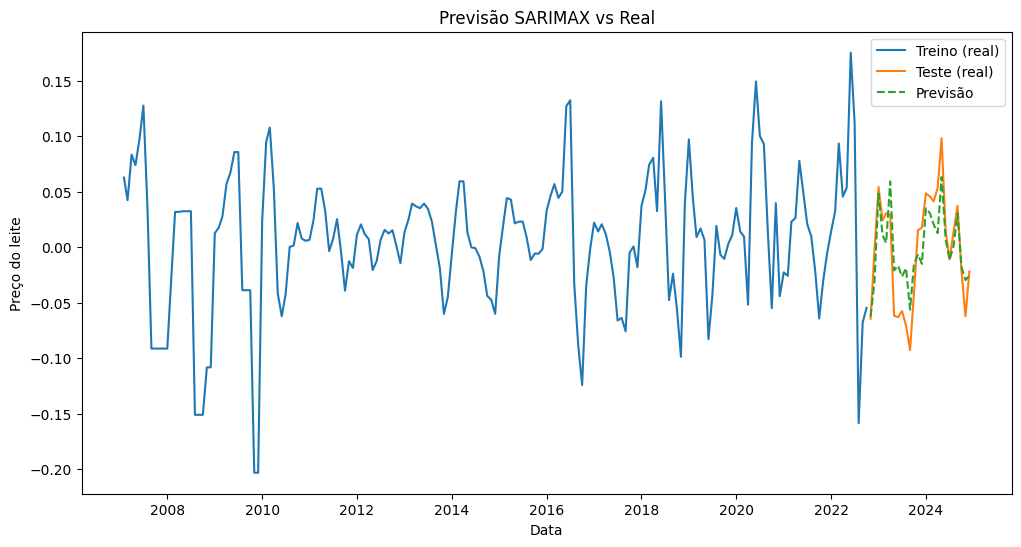

In [89]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Treino (real)')
plt.plot(y_test.index, y_test, label='Teste (real)')
plt.plot(y_pred.index, y_pred, label='Previsão', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Preço do leite')
plt.title('Previsão SARIMAX vs Real')
plt.legend()
plt.show()

### Análise do Modelo SARIMAX para Previsão do Preço do Leite

Foi utilizado um modelo SARIMAX para prever o preço do leite pago ao produtor. Antes de ajustar o modelo, a série de preços foi transformada com logaritmo para estabilizar a variância e melhorar o desempenho do modelo. Após gerar as previsões, os valores foram convertidos de volta para a escala original para facilitar a interpretação.

As previsões foram então comparadas com os dados reais do conjunto de teste para avaliar a qualidade do modelo.

**Resultados (na escala original dos preços)**

- **RMSE (erro quadrático médio):** 0.1925  
- **MAE (erro absoluto médio):** 0.1449

Esses números indicam que, em média, o modelo errou entre 14 e 19 centavos por previsão. Considerando que os preços reais variam entre aproximadamente R$0,45 e R$2,86 ao longo da série, os erros estão dentro de um intervalo aceitável. Isso mostra que o modelo conseguiu capturar bem a dinâmica da série de preços.


Visualmente, é possível perceber que as previsões seguem de forma coerente o comportamento real dos preços, inclusive acompanhando os padrões de subida e descida do período de teste.

Conclusão

O modelo SARIMAX se mostrou eficiente para prever o preço do leite ao produtor. Ele apresentou erros baixos e um comportamento de previsão que condiz com os dados reais, tanto em termos de tendência quanto de sazonalidade. Isso o torna uma boa ferramenta para análise e projeção futura dessa variável.

In [109]:
caminho = r'C:\Users\eduar\OneDrive\Documentos\SandoBox\Projetos\PriceCast\modelo\modelo_sarimax.pkl'

diretorio = os.path.dirname(caminho)
if not os.path.exists(diretorio):
    os.makedirs(diretorio)  # Cria o diretório se ele não existir

with open(caminho, 'wb') as f:
    pickle.dump(modelo_sarimax, f)

print(f"Modelo salvo com sucesso em:\n{caminho}")

Modelo salvo com sucesso em:
C:\Users\eduar\OneDrive\Documentos\SandoBox\Projetos\PriceCast\modelo\modelo_sarimax.pkl
